# CPU Accelerated Fine-Tuning for Image Segmentation using PyTorch

**Abstract**: PyTorch delivers great CPU performance, and it can be further accelerated with Intel® Extension for PyTorch* (IPEX). I will walk you through a real-world example of training an AI image segmentation model using PyTorch* 1.13.1 (with ResNet34 architecture); the model will learn to identify roads and speed limits from satellite images, all on the newly released 4th Gen Intel® Xeon® Scalable Processor (Sapphire Rapids).

-----
Author: Ben Consolvo | Company: Intel | 
Date: March 4, 2023 <br><br>
<a href="https://discord.gg/rv2Gp55UJQo" target="Discord"> <img src="https://upload.wikimedia.org/wikipedia/en/9/98/Discord_logo.svg" width="100"/></a> <br> Please join me on Intel's Developer Discord to have further discussion following the talk. **My user is <mark>silvos#5002</mark>** <br>
Invite link: https://discord.gg/rv2Gp55UJQ <br>


*You can also connect with me here*:
## <a href="https://www.linkedin.com/in/bconsolvo/" target="LinkedIn"> <img src="https://upload.wikimedia.org/wikipedia/commons/0/01/LinkedIn_Logo.svg" width="60"/></a> | <a href="https://twitter.com/bpconsolvo" target="Twitter"> <img src="https://upload.wikimedia.org/wikipedia/commons/4/4f/Twitter-logo.svg" width="25"/></a> | <a href="https://huggingface.co/bconsolvo" target=""> <img src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="30"/></a> | <a href="https://www.kaggle.com/bconsolvo" target="Kaggle"> <img src="https://www.kaggle.com/static/images/site-logo.svg" width="60"/></a> | <a href="https://www.quora.com/profile/Benjamin-Consolvo" target="Quora"> <img src="https://upload.wikimedia.org/wikipedia/commons/9/91/Quora_logo_2015.svg" width="40"/></a> | <a href="https://www.reddit.com/user/bconsolvo" target="Reddit"> <img src="https://upload.wikimedia.org/wikipedia/commons/b/b4/Reddit_logo.svg" width="40"/></a> | <a href="https://stackoverflow.com/users/12363294/bconsolvo" target="Stack Overflow"> <img src="https://upload.wikimedia.org/wikipedia/commons/0/02/Stack_Overflow_logo.svg" width="90"/></a> | <a href="https://www.twitch.tv/silvosjehoaddah" target="Twitch"> <img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Twitch_logo.svg" width="40"/></a> |  <a href="https://github.com/bconsolvo" target="GitHub"> <img src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" width="25"/></a>
<br>


-----

**Introduction** <br><br>
I am excited to be able to show you today that CPUs are viable to train a deep learning model for a fine-tuning example. 

> <mark>In this tutorial, you will learn how to accelerate a PyTorch training job with Sapphire Rapids. We will use the [Intel Extension for PyTorch (IPEX)](https://github.com/intel/intel-extension-for-pytorch) library to enable built-in AI acceleration on the Sapphire Rapids CPU to work with minimal code changes. You will learn how to train a satellite image with matching street labels (pixel segmentation task) example. </mark>

The potential cost savings for renting a CPU on one of the major CSPs, instead of a GPU, are significant. However, I will say that the latest CPU processors are still being rolled out to the CSPs, and it is typical for there to be a lag time to availability on the major CSPs from launch-date. The Sapphire Rapids CPU I will show you today is a beast! It is being hosted on the **Intel® Developer Cloud***, which you can sign up for the Beta here: [cloud.intel.com](https://cloud.intel.com). If you want free access, please get in touch with me after the talk today.

> <mark>Coming soon, I will provide a new tutorial around using PyTorch 2.0 after its release on March 14, 2023.</mark>

-----

**Key References** <br><br>
Much of my material and code was taken from the CRESI repository below. I've adapted it for use on Sapphire Rapids, with optimizations from [Intel Extension for PyTorch](https://github.com/intel/intel-extension-for-pytorch).
- https://github.com/avanetten/cresi 

In particular, I was able to piece together a workflow using the notebooks here:
- https://github.com/avanetten/cresi/tree/main/notebooks

I also highly recommend these Medium articles for another detailed explanation of how to get started with the SpaceNet5 data:
- [The SpaceNet 5 Baseline — Part 1: Imagery and Label Preparation](https://medium.com/the-downlinq/the-spacenet-5-baseline-part-1-imagery-and-label-preparation-598af46d485e)
- [The SpaceNet 5 Baseline — Part 2: Training a Road Speed Segmentation Model](https://medium.com/the-downlinq/the-spacenet-5-baseline-part-2-training-a-road-speed-segmentation-model-2bc93de564d7)
- [The SpaceNet 5 Baseline — Part 3: Extracting Road Speed Vectors from Satellite Imagery](https://medium.com/the-downlinq/the-spacenet-5-baseline-part-3-extracting-road-speed-vectors-from-satellite-imagery-5d07cd5e1d21)
- [SpaceNet 5 Winning Model Release: End of the Road](https://medium.com/the-downlinq/spacenet-5-winning-model-release-end-of-the-road-fd02e00b826c)

I also referenced 2 Hugging Face blogs by Julien Simon here. He ran his tests on the AWS* instance `r7iz.metal-16xl` :
- [Accelerating PyTorch Transformers with Intel Sapphire Rapids, part 1](https://huggingface.co/blog/intel-sapphire-rapids)
- [Accelerating PyTorch Transformers with Intel Sapphire Rapids, part 2](https://huggingface.co/blog/intel-sapphire-rapids-inference)

-----
**Intro to Hardware: 4th Gen Intel® Xeon® Scalable Processor (Sapphire Rapids) - CPU specs**
- Released in January of 2023
- 2 sockets
- 56 physical cores (112 vCPUs) per socket
- 224 vCPUs total
- 504 GB of memory
- New Intel® Advanced Matrix Extensions (Intel® AMX), a built-in AI acceleration engine.
    - Supports BF16 and INT8 data types

-----
**Intro to Software and AI Optimizations**

How do AI framework optimizations help? 3 main ways:
1. Operator level - Parallelism (SIMD, thread), mixed precision and quantization, data layout optimizations (eg., channel last)
2. Graph level - Operator fusion (eg., conv + relu fusion, constant folding)
3. Runtime - Thread affinity, multi-streams, NUMA control, memory pooling

- OpenMP: 
    - Provides shared memory parallel processing for PyTorch (and IPEX)
    - Accelerates tensor operations like CONV2D
    - Map OpenMP threads to physical cores
    - Set number of threads to available cores (minimizes cache contention and likelihood of false sharing & cache thrashing)
    - Optimized runtime config for most AI workloads:
```bash
export OMP_NUM_THREADS=<physical_cores_allocated>
export KMP_AFFINITY=compact,granularity=fine  
export KMP_BLOCKTIME=1 (0r 0, default is 200ms, idle wait time)
```

- NUMA:
    - localizes memory access
    - Minimize overheads using `numactl`. For example:
```bash
numactl -C 0-<n-cores>  --membind=<memory-node-id> <command>
numactl -C 0-35 --membind=0 train.py
```
where 0-35 are the physical cores, memory-node-id would be in our case 0 or 1 where we want to specify to stay on one of the two sockets, and then the command would be the script to run.

*Both PyTorch and IPEX have helper scripts so that you don't have to explicitly use `numactl` and set OpenMP environment variables, but they need to be installed so they can work in the backend.*

**PyTorch for CPU** 
- Intel's main goal is to make default PyTorch simple to use and performant on CPUs, by upstreaming all optimizations into the main branch of PyTorch. 
- Uses OpenMP for multi-threading
- Upstreamed oneDNN provides optimized DNN primitives for Intel CPUs

**Intel Extension for PyTorch (IPEX)**
-  Provides additional acceleration that has not yet made it into the stock package
- Early access to optimized kernels
- Runtime extensions
- Mixed precision with BF16 (at the time of writing - should soon be upstreamed into stock). 
    - BF16 data-type requires only half storage of FP32 data-type, which reduces both memory bandwidth and computation when applicable 
- Quantized inference
- Async tasks
- [IPEX GitHub link](https://github.com/intel/intel-extension-for-pytorch) | [IPEX Product page](https://www.intel.com/content/www/us/en/developer/tools/oneapi/optimization-for-pytorch.html#gs.qag6mc)

For more details on oneDNN and BF16, you can take a look at this Medium article, published on 02/03/2021: [Accelerate PyTorch with IPEX and oneDNN using Intel BF16 Technology](https://medium.com/pytorch/accelerate-pytorch-with-ipex-and-onednn-using-intel-bf16-technology-dca5b8e6b58f).

3 tools to be aware of that we will cover in today's workshop:
1. `ipex.optimize`
2. Auto Mixed Precision:
```python
with torch.no_grad():
    with torch.cpu.amp.autocast():
        <forward-prediction-code>
```
3. PyTorch CPU launcher: `ipexrun`
-----
Model Architecture:
- ResNet34 + UNet (see winning model from [SpaceNet 5 Winning Model Release: End of the Road](https://medium.com/the-downlinq/spacenet-5-winning-model-release-end-of-the-road-fd02e00b826c)).

Operating System:
- Ubuntu* 22.04

In [1]:
!lscpu 

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         52 bits physical, 57 bits virtual
  Byte Order:            Little Endian
CPU(s):                  224
  On-line CPU(s) list:   0-223
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) Platinum 8480+
    CPU family:          6
    Model:               143
    Thread(s) per core:  2
    Core(s) per socket:  56
    Socket(s):           2
    Stepping:            8
    CPU max MHz:         3800.0000
    CPU min MHz:         800.0000
    BogoMIPS:            4000.00
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss 
                         ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art
                          arch_perfmon pebs bts rep_good nopl xtopology nonstop_
                         tsc cpuid aperfmperf tsc_known_freq pni pclmulqdq dtes6
   

#### Flags for AMX
Under "flags", you can see `amx_bf16`, `amx_tile`, and `amx_int8`, so you know AMX is available for use.

# Environment setup
The environment setup will depend on what already comes installed on the machine you are using, but here is a guide on what I did. To simplify the environment setup, I wrote out here what I did to get my environment set up properly. Please note that you may need to make adjustments depending on the build and configuration of your machine. I have just left these to be run in the command line, as opposed to in the notebook, as the text output gets too long for a notebook.

0. **Registration on Intel Developer Cloud** <br>
To get access to the latest Intel computing hardware:
    - You can sign up for the beta here: [cloud.intel.com](https://cloud.intel.com)
    - Head over to the [Get Started](https://scheduler.cloud.intel.com/public/Intel_Developer_Cloud_Getting_Started.html) page on how to set up an instance
    - I used the "4th Generation Intel® Xeon® Scalable processors" instance.
-----

1. **Building backend software with `apt-get`** <br>
Installing apt-get packages
```bash
#Fix broken installs (if any) for apt-get
sudo apt-get --fix-broken install

#Update apt-get
sudo apt-get update
sudo apt-get autoremove

#Install packages
sudo apt-get install -y \
    cdo \
    nco \
    gdal-bin \
    libgdal-dev \
    libjemalloc-dev \
    awscli \
    cmake \
    apt-utils \
    python3-dev \
    libssl-dev \
    libffi-dev \
    libncurses-dev \
    libgl1 \
    ffmpeg \
    libsm6 \
    libxext6 \
    numactl
```
Two key installs here for getting the most out of the hardware are `numactl` and `libjemalloc-dev`.

-----

2. **Setting up Anaconda environment** <br>
Building Anaconda environment and installing some packages with `conda install`.
```bash
#Download and install Miniconda distribution of Anaconda
wget https://repo.anaconda.com/miniconda/Miniconda3-py38_23.1.0-1-Linux-x86_64.sh -O ~/miniconda.sh && \
    sudo /bin/bash ~/miniconda.sh -b -p /opt/conda && \
    rm ~/miniconda.sh && \
    sudo /opt/conda/bin/conda clean -tip && \
    sudo ln -s /opt/conda/etc/profile.d/conda.sh /etc/profile.d/conda.sh && \
    sudo echo ". /opt/conda/etc/profile.d/conda.sh" >> ~/.bashrc && \
    source ~/.bashrc
    
#Create new conda environment
conda create --name py39 python=3.9
echo "conda activate py39" >> ~/.bashrc
source ~/.bashrc

#install conda packages
conda install -c conda-forge libgdal
conda install tiledb=2.2
conda install poppler
conda install intel-openmp
conda install gperftools -c conda-forge

```
Two key installs here for getting the most out of the hardware are `gperftools` and `intel-openmp`.

-----

3. **Installing pip packages** <br>
Installing PyTorch for CPU, as well as a `requirements.txt` file of packages
```bash
#pip upgrades
python -m pip install --upgrade pip wheel
pip3 install setuptools==57.5.0 #for 3rd gen xeon

#install torch for CPU
pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

#install requirements packages
pip3 install -r requirements.txt

#put the newly created conda environment into Jupyter*
python -m ipykernel install --user --name=py39

#install oneCCL if want to launch more complicated (distributed) jobs
#python -m pip install oneccl_bind_pt==1.13 -f https://developer.intel.com/ipex-whl-stable-cpu

```
The `requirements.txt` is:
```python
scikit-image
jupyterlab
ipykernel
numpy
pandas
scipy
matplotlib
fiona
opencv-python
shapely
imagecodecs
tqdm
osmnx
torchsummary
geopandas==0.6.3
tensorboardX
tensorboard
networkx==2.8
numba
utm
intel_extension_for_pytorch
gdal==3.0.4
```
-----

4. **Cloning cresi repository** <br>
The cresi repository contains a lot of the code needed to run training and inference in this demo. Navigate to the folder where you want to store the `cresi` repo and go ahead and clone it with:
```bash
git clone https://github.com/avanetten/cresi
```
-----

5. **Downloading SpaceNet 5 data from AWS S3 bucket** <br>
For this tutorial we will use public imagery from the [SpaceNet 5 Challenge](https://spacenet.ai/sn5-challenge/).  These weights and images are are part of the [Registry of Open Data on AWS](https://registry.opendata.aws/spacenet/), and can be downloaded for free.  You will need an AWS account to access the data, and the AWS CLI tool installed. Then, simply execute `aws configure` from the command line and input your **AWS Access Key ID** and your **AWS Secret Access Key**. <br>Once AWS CLI is setup, you should be able to download the dataset directly from the public S3 bucket below. There are both **train** and **test** datasets listed below. The train datasets contain labels, while the test datasets do not contain labels. The commands below list all of the available relevant data, zipped up into .tar.gz files.


In [2]:
!aws s3 ls s3://spacenet-dataset/spacenet/SN5_roads/tarballs/ --human-readable

2019-09-03 20:59:32    5.8 GiB SN5_roads_test_public_AOI_7_Moscow.tar.gz
2019-09-24 08:43:02    3.2 GiB SN5_roads_test_public_AOI_8_Mumbai.tar.gz
2019-09-24 08:43:47    4.9 GiB SN5_roads_test_public_AOI_9_San_Juan.tar.gz
2019-09-14 13:13:26   35.0 GiB SN5_roads_train_AOI_7_Moscow.tar.gz
2019-09-14 13:13:34   18.5 GiB SN5_roads_train_AOI_8_Mumbai.tar.gz


In [3]:
!aws s3 ls s3://spacenet-dataset/spacenet/SN3_roads/tarballs/ --human-readable

2019-08-23 12:09:19  728.8 MiB SN3_roads_sample.tar.gz
2019-08-23 11:34:23    8.1 GiB SN3_roads_test_public_AOI_2_Vegas.tar.gz
2019-08-23 11:35:30    1.8 GiB SN3_roads_test_public_AOI_3_Paris.tar.gz
2019-08-23 11:30:48    8.0 GiB SN3_roads_test_public_AOI_4_Shanghai.tar.gz
2019-08-23 11:31:55    1.6 GiB SN3_roads_test_public_AOI_5_Khartoum.tar.gz
2019-08-21 10:27:25   24.3 GiB SN3_roads_train_AOI_2_Vegas.tar.gz
2019-09-03 12:00:38    1.4 MiB SN3_roads_train_AOI_2_Vegas_geojson_roads_speed.tar.gz
2019-08-21 10:27:25    5.5 GiB SN3_roads_train_AOI_3_Paris.tar.gz
2019-09-03 12:01:25  234.7 KiB SN3_roads_train_AOI_3_Paris_geojson_roads_speed.tar.gz
2019-08-21 10:27:25   24.0 GiB SN3_roads_train_AOI_4_Shanghai.tar.gz
2019-09-03 12:01:47    1.6 MiB SN3_roads_train_AOI_4_Shanghai_geojson_roads_speed.tar.gz
2019-08-21 10:27:25    4.9 GiB SN3_roads_train_AOI_5_Khartoum.tar.gz
2019-09-03 12:02:16  486.4 KiB SN3_roads_train_AOI_5_Khartoum_geojson_roads_speed.tar.gz


As you can see above, some of these files are multiple GBs, so please be aware of your space on your local disk before downloading.

**An example of downloading a specific file and unzipping**
```bash
aws s3 cp s3://spacenet-dataset/spacenet/SN5_roads/tarballs/SN5_roads_train_AOI_7_Moscow.tar.gz .
tar -xvzf ~/spacenet5data/moscow/SN5_roads_train_AOI_7_Moscow.tar.gz
```

**An example of downloading a whole folder from S3**
```bash
!aws s3 cp s3://spacenet-dataset/spacenet/SN3_roads/tarballs/ . --recursive
```
-----



6. **Launching Jupyter Labs*** <br>
I have some instructions for launching Jupyter Lab on the Intel Developer Cloud instance, and then how you would connect in from your local machine on a web browser. After you have installed Jupyter Lab from the previous steps, from the command line, you can launch a Jupyter server.  I prefer to do this in a `tmux` window, so that I can exit out still use the same terminal window. You can read more about [tmux here on their GitHub](https://github.com/tmux/tmux/wiki). You can use the provided script:
```bash
jupyter lab --port=8080 --ServerApp.ip=* --no-browser
```
In order to be able to connect to the Jupyter server on a local browser, you can create an SSH tunnel with a command like the following in a different terminal window (connecting your local machine to the remote machine):
```bash
ssh -J guest@146.152.226.42 -L 8080:localhost:8080 devcloud@192.168.19.2
```
You should now be able to go to a local browser and enter the URL below to access your Jupyter server <br>
https://localhost:8080

In [4]:
#Command to show how much room you have available on disk
!df -h

Filesystem      Size  Used Avail Use% Mounted on
tmpfs            51G  4.0M   51G   1% /run
/dev/nvme0n1p2  3.5T  415G  2.9T  13% /
tmpfs           252G  160K  252G   1% /dev/shm
tmpfs           5.0M     0  5.0M   0% /run/lock
/dev/nvme0n1p1  537M  5.3M  532M   1% /boot/efi
tmpfs            51G  4.0K   51G   1% /run/user/1000


# Python* Package Imports for Notebook

In [5]:
#importing packages
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import json
import pandas as pd

%load_ext autoreload
%autoreload 2

# Image Dataset Preparation - Making Masks

The images have names like the following: `SN5_roads_train_AOI_7_Moscow_PS-RGB_chip180.tif` 
- `SN5` means SpaceNet 5 
- `PS-MS` means pan-sharpened (PS) 8-band multispectral (MS) image 
- `PS-RGB` means pan-sharpened (PS) 3-band RGB image 

The 8-band multispectral images are of shape `(1300,1300,8)`, whereas the RGB images are of shape `(1300,1300,3)`. Here in the notebook I only show the 3-channel RGB images, but feel free to explore ways to visualize the 8-band images.


Each "clip" of a satellite image has corresponding labels of where the streets are located. We need will teach a neural network about, so it can predict where streets are based on the satellite image alone. 


> After unzipping the `SN5_roads_train_AOI_7_Moscow.tar.gz` file, you should find the `geojson_roads_speed` folder within each area of interest (AOI) directory (`nfs/data/cosmiq/spacenet/competitions/SN5_roads/tiles_upload/train/AOI_7_Moscow/geojson_roads_speed`). It contains road centerline labels along with estimates of safe travel speeds for each roadway.  We'll use these centerline labels and speed estimates to create training masks. We assume a mask buffer of 2 meters, meaning that each roadway is assigned a total width of 4 meters.  Remember that the goal of our segmentation step is to detect road centerlines, so while this is not the precise width of the road, a buffer of 2 meters is an appropriate width for our segmentation model.

> One option for training a segmentation model is to create training masks where the value of the mask is proportional to the speed of the roadway. This can be accomplished by running the `speed_masks.py` script (https://github.com/avanetten/cresi/blob/main/cresi/data_prep/speed_masks.py).
```bash
python3 /home/devcloud/cresi/cresi/data_prep/speed_masks.py --geojson_dir=/home/devcloud/spacenet5data/moscow/data/geojson_roads_speed \
        --image_dir=/home/devcloud/spacenet5data/moscow/data/PS-MS \
        --output_conversion_csv_binned=/home/devcloud/spacenet5data/moscow/data/v6/output_conversion_csv_binned/sn5_roads_train_speed_conversion_binned.csv \
        --output_mask_dir=/home/devcloud/spacenet5data/moscow/data/v6/train_mask_binned \
        --output_mask_multidim_dir=/home/devcloud/spacenet5data/moscow/data/v6/train_mask_binned_mc \
        --buffer_distance_meters=2 \
        --crs=None
```
**Displaying Satellite Images and Corresponding Image Masks** <br>
Below, I am showing a sample of some of the satellite images in RGB format (each image is an array of shape (1300,1300,3), where 1300x1300 is the pixel count, and 3 are the three R-G-B color channels.

The generated mask images are the corresponding masks to these specific clips. The different colors of the roads indicate different speed limits.

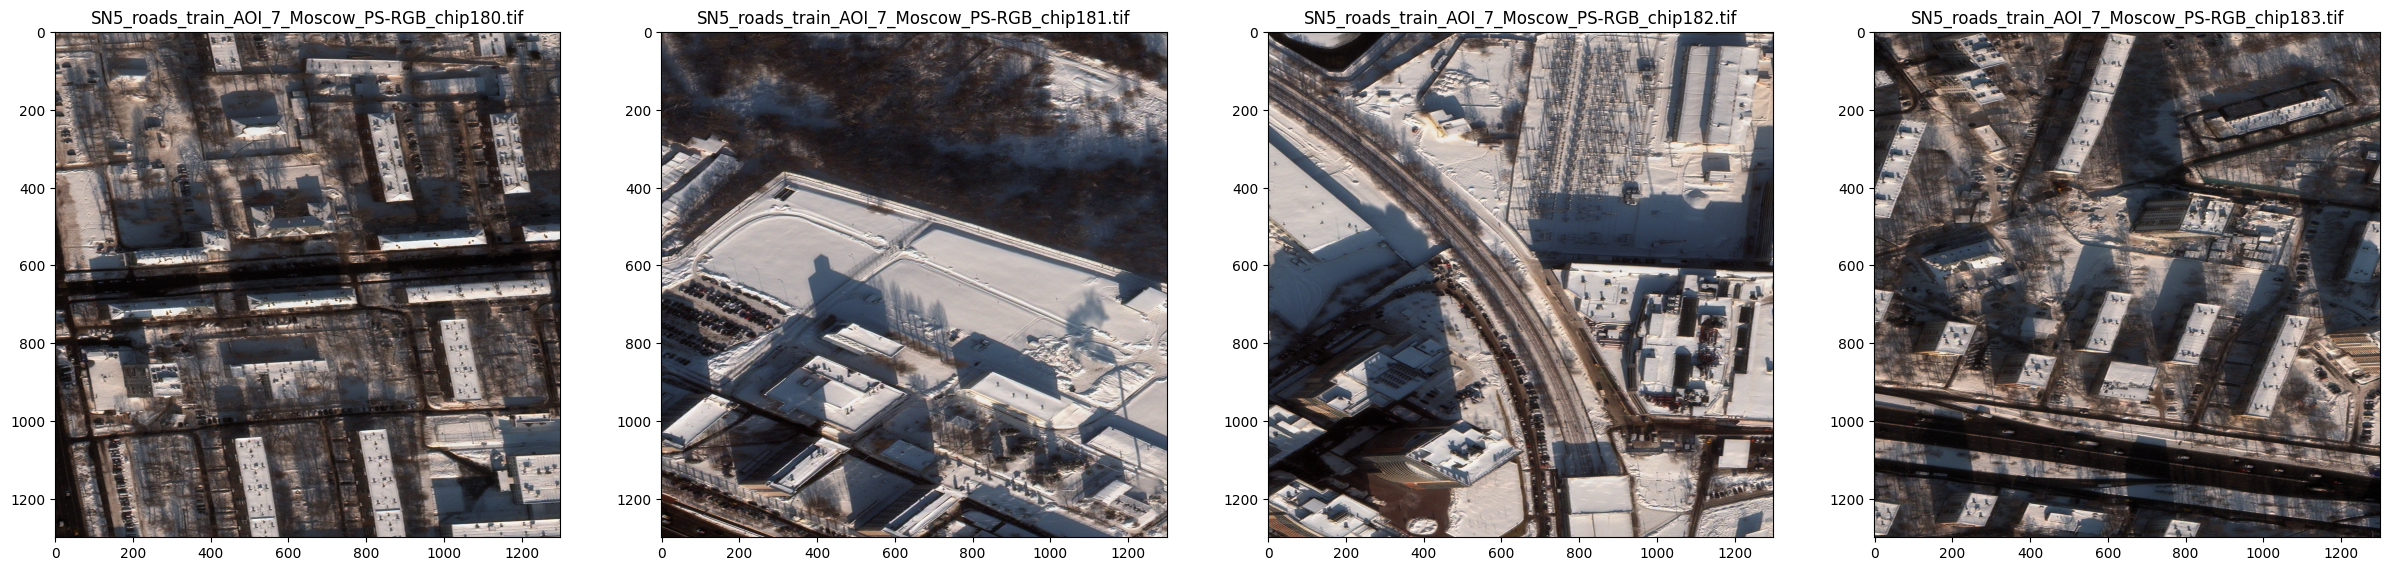

Image array shape is (1300, 1300, 3)


In [6]:
#Showing some sample images
image_dir = '/home/devcloud/spacenet5data/moscow/train_data/PS-RGB' #replace with your local path to the images
image_names = ['SN5_roads_train_AOI_7_Moscow_PS-RGB_chip180.tif',
               'SN5_roads_train_AOI_7_Moscow_PS-RGB_chip181.tif',
               'SN5_roads_train_AOI_7_Moscow_PS-RGB_chip182.tif',
               'SN5_roads_train_AOI_7_Moscow_PS-RGB_chip183.tif']
full_path_images = [Path(image_dir,img) for img in image_names]

fig = plt.figure(figsize=(30, 10))
columns = 4
rows = 1
ax = []
for idx,num in enumerate(range(columns*rows)):
    img = skimage.io.imread(full_path_images[idx])
    ax.append(fig.add_subplot(rows,columns,num+1))
    ax[-1].set_title(image_names[idx])
    plt.imshow(img)
plt.show()
print(f'Image array shape is {img.shape}')

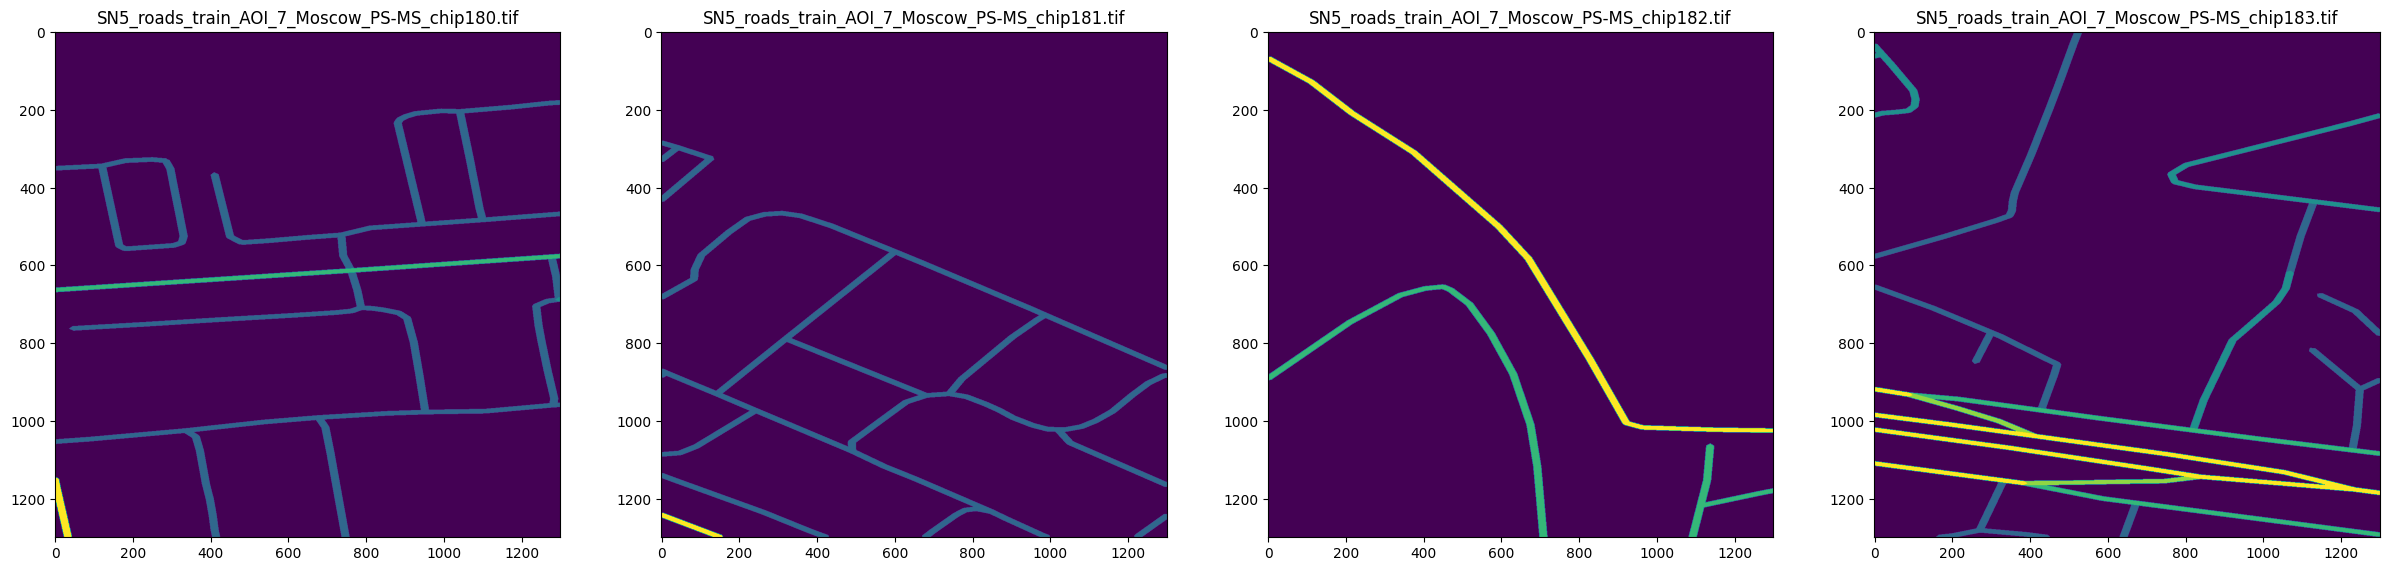

Image array shape is (1300, 1300)


In [7]:
#Showing some sample images
image_dir = '/home/devcloud/spacenet5data/moscow/v10/train_mask_binned/' #replace with your local path to the images
image_names = ['SN5_roads_train_AOI_7_Moscow_PS-MS_chip180.tif',
               'SN5_roads_train_AOI_7_Moscow_PS-MS_chip181.tif',
               'SN5_roads_train_AOI_7_Moscow_PS-MS_chip182.tif',
               'SN5_roads_train_AOI_7_Moscow_PS-MS_chip183.tif']
full_path_images = [Path(image_dir,img) for img in image_names]

fig = plt.figure(figsize=(30, 10))
columns = 4
rows = 1
ax = []
for idx,num in enumerate(range(columns*rows)):
    img = skimage.io.imread(full_path_images[idx])
    ax.append(fig.add_subplot(rows,columns,num+1))
    ax[-1].set_title(image_names[idx])
    plt.imshow(img)
plt.show()
print(f'Image array shape is {img.shape}')

# Training Configuration Prep

**Building Configuration JSON for train/validation split and training parameters** <br>
First, we need to build a JSON configuration file that defines how we will split up the image data into training and validation sets, and define our training parameters. The location of the default configuration file should be found in your cloned cresi directory. You can find a sample config here: <br> https://github.com/avanetten/cresi/blob/main/cresi/configs/sn5_baseline_aws.json. <br><br>
My edited config file looks like:
```python
{
    "path_src": "/home/devcloud/cresi/cresi",
    "path_results_root": "/home/devcloud/spacenet5data/moscow/v10_xeon4_devcloud22.04", 
    "train_data_refined_dir_ims": "/home/devcloud/spacenet5data/moscow/train_data/PS-MS",
    "train_data_refined_dir_masks": "/home/devcloud/spacenet5data/moscow/v10/train_mask_binned_mc",
    "speed_conversion_file": "/home/devcloud/spacenet5data/moscow/v10/output_conversion_csv_binned/sn5_roads_train_speed_conversion_binned.csv",
    "folds_file_name": "folds4.csv",
    "save_weights_dir": "sn5_baseline",
    "num_folds": 1,
    "default_val_perc": 0.2,
    "num_channels": 8,
    "num_classes": 8,
    "network": "resnet34",
    "loss": {
        "soft_dice": 0.25,
        "focal": 0.75
    },
    "early_stopper_patience": 8,
    "nb_epoch": 30,
    "test_data_refined_dir": "/home/devcloud/spacenet5data/moscow/test_data/PS-MS",
    "test_results_dir": "sn5_baseline",
    "folds_save_dir": "folds",
    "tile_df_csv": "tile_df.csv",
    "test_sliced_dir": "",
    "slice_x": 0,
    "slice_y": 0,
    "stride_x": 0,
    "stride_y": 0,
    "skeleton_band": 7,
    "skeleton_thresh": 0.3,
    "min_subgraph_length_pix": 20,
    "min_spur_length_m": 10,
    "GSD": 0.3,
    "rdp_epsilon": 1,
    "log_to_console": 1,
    "intersection_band": -1,
    "use_medial_axis": 0,
    "merged_dir": "merged",
    "stitched_dir_raw": "stitched/mask_raw",
    "stitched_dir_count": "stitched/mask_count",
    "stitched_dir_norm": "stitched/mask_norm",
    "wkt_submission": "wkt_submission_nospeed.csv",
    "skeleton_dir": "skeleton",
    "skeleton_pkl_dir": "sknw_gpickle",
    "graph_dir": "graphs",
    "padding": 22,
    "eval_rows": 1344,
    "eval_cols": 1344,
    "batch_size": 64,
    "iter_size": 1,
    "lr": 0.0001,
    "lr_steps": [
        20,
        25
    ],
    "lr_gamma": 0.2,
    "test_pad": 64,
    "epoch_size": 8,
    "predict_batch_size": 33,
    "target_cols": 512,
    "target_rows": 512,
    "optimizer": "adam",
    "warmup": 0,
    "ignore_target_size": false
}
```

Code to load JSON into Jupyter:
```python
training_config = '/home/devcloud/cresi/cresi/configs/ben/v10_xeon4_baseline_ben.json'
f = open(training_config)
obj = json.load(f)
print(json.dumps(obj, indent=4))
```

Here are a few elaborations on some of these parameters: <br>

| parameter | description | 
| --------- | ---------- | 
| `path_src` | directory to local clone of cresi repository folder | 
| `path_results_root` | directory where all results are saved, including the split of training and validation data, and trained model weights. | 
| `train_data_refined_dir_ims` | directory where all of the training images reside. For example, `SN5_roads_train_AOI_7_Moscow_PS-MS_chip1241.tif` is one of the images in this directory. |
| `train_data_refined_dir_masks` | directory where the mask images reside. These images are generated with the [`speed_masks.py`](https://github.com/avanetten/cresi/blob/main/cresi/data_prep/speed_masks.py) script referenced earlier. The images should have the exact same name as the training images. | 
| `speed_conversion_file` | path to the binned speed conversion CSV file. It should have 3 columns and look like: `burn_val,speed,channel` with the first line looking like `36,1,0`. Speeds are in miles per hour, and there are 7 possible output channels for speeds, and the 8th channel is an aggregate of the rest. |
| `folds_file_name` | This file will be saved in the `path_results_root` / `weights` / `save_weights_dir` directory. It is simply a list of the image file names, along with which fold number. `SN5_roads_train_AOI_7_Moscow_PS-MS_chip379.tif,0`. If the fold number is 0 in our case, it is part of the validation set.
| `save_weights_dir` | Directory where model weights are saved in `path_results_root` / `weights` path. 
| `num_folds` | Number of validation fold datasets. "Using multiple cross-validated models can improve performance, though at the expense of increased run time at inference. For our baseline we use only a single fold, and randomly withhold 20% of the data for validation purposes during training. We use this validation data to test performance after each epoch, and truncate training if the validation loss does not decrease for 8 epochs." ([Source](https://medium.com/the-downlinq/the-spacenet-5-baseline-part-2-training-a-road-speed-segmentation-model-2bc93de564d7)) |
| `default_val_perc` | Percentage of data for validation during training. | 
| `num_channels` | The number of channels in the training image. For PS-MS pan-sharpened (PS) 8-band multispectral (MS) images, you can put 8. If using PS-RGB pan-sharpened (PS) 3-band RGB images, you can put 3. | 
| `num_classes` | Number of bins of speed limits. In our case, we have binned the data into 8 speed limit buckets. | 
| `network` | Neural network architecture. Choices at the time of writing are: `resnet34`, `resnet50`, `resnet101`,`seresnet50`,`seresnet101`,`seresnet152`, `seresnext50`, or `seresnext101`. The choice of model architecture will influence the speed and accuracy of training. | 
| `loss` | Type of loss function. "Custom loss function comprised of 25% Dice Loss and 75% Focal Loss." ([Source](https://medium.com/the-downlinq/the-spacenet-5-baseline-part-2-training-a-road-speed-segmentation-model-2bc93de564d7)) | 
| `nb_epoch` | Number of epochs | 
| `batch_size` | Number of images to use in one batch to load into memory. Note that this can be increased or decreased depending on your memory requirements. |  
| `optimizer` | Optimizers at the time of writing that can be chosen are: `adam`, `rmsprop`, and `sgd`. | 

There are numerous other configuration parameters that can be adjusted for training time and inference time, but we will leave those alone.

**Creating Validation Fold** <br>
We need to create the validation fold of data. To do that, we can use the `00_gen_folds.py` script (https://github.com/avanetten/cresi/blob/main/cresi/00_gen_folds.py) with the previously configured parameter file. For example, I ran:
```
!python3 /home/devcloud/cresi/cresi/00_gen_folds.py /home/devcloud/cresi/cresi/configs/ben/v5_sn5_baseline_ben.json
```
The output is a folds CSV file: `/home/devcloud/spacenet5data/moscow/results_xeon4_devcloud/weights/sn5_baseline/folds4.csv`

There are folds 0, 1, 2, 3, and 4. The validation data are fold 0 (20%), and the training data are folds 1-4 (80%).

In [8]:
folds = '/home/devcloud/spacenet5data/moscow/v10_xeon4_devcloud22.04/weights/sn5_baseline/folds4.csv'
pd.read_csv(folds)

Unnamed: 0  fold
0      SN5_roads_train_AOI_7_Moscow_PS-MS_chip842.tif     0
1     SN5_roads_train_AOI_7_Moscow_PS-MS_chip1327.tif     1
2      SN5_roads_train_AOI_7_Moscow_PS-MS_chip561.tif     2
3       SN5_roads_train_AOI_7_Moscow_PS-MS_chip91.tif     3
4     SN5_roads_train_AOI_7_Moscow_PS-MS_chip1263.tif     4
...                                               ...   ...
1348   SN5_roads_train_AOI_7_Moscow_PS-MS_chip843.tif     3
1349   SN5_roads_train_AOI_7_Moscow_PS-MS_chip932.tif     4
1350  SN5_roads_train_AOI_7_Moscow_PS-MS_chip1032.tif     0
1351  SN5_roads_train_AOI_7_Moscow_PS-MS_chip1168.tif     1
1352   SN5_roads_train_AOI_7_Moscow_PS-MS_chip761.tif     2

[1353 rows x 2 columns]

### Codebase Changes


I had to make some minor code changes to the `cresi` repo, described below, in order to run with the new Intel CPU with AMX.
***

1. **Make sure that the code runs natively on a CPU, instead of a GPU.**
    - In https://github.com/avanetten/cresi/blob/main/cresi/net/pytorch_utils/train.py: 
        - Replace `self.model = nn.DataParallel(model).cuda()` with `self.model = nn.DataParallel(model)`
    - In https://github.com/avanetten/cresi/blob/main/cresi/01_train.py:
        - Remove `torch.randn(10).cuda()`

***

2. **Optimize the training code with Intel Extension for PyTorch, to get the most benefit out of training on a CPU.**
    - In https://github.com/avanetten/cresi/blob/main/cresi/net/pytorch_utils/train.py:
        - Add `import intel_extension_for_pytorch as ipex` with the import statements
        - Add line for IPEX optimization and bfloat16 for mixed precision training just after defining the model and optimizer: 
        
            ```python
            self.model = nn.DataParallel(model) #.cuda() only for GPU
            self.optimizer = optimizer(self.model.parameters(), lr=config.lr)
            ```
            `self.model, self.optimizer = ipex.optimize(self.model, optimizer=self.optimizer,dtype=torch.bfloat16)`
        - Add a line to do mixed precision on CPU just before running a forward pass and calculating the loss function:
            
            `with torch.cpu.amp.autocast():`
            ```python
                if verbose:
                    print("input.shape, target.shape:", input.shape, target.shape)
                output = self.model(input)
                meter = self.calculate_loss_single_channel(output, target, meter, training, iter_size)
            ```
***
3. **Optimize inference code with Intel Extension for PyTorch**
    - In https://github.com/avanetten/cresi/blob/main/cresi/net/pytorch_utils/eval.py:
        - Add `import intel_extension_for_pytorch as ipex` in the imports
        - After loading the PyTorch model, use IPEX to optimize the model for bfloat16 inference
            ```python
            model = torch.load(os.path.join(path_model_weights, 'fold{}_best.pth'.format(fold)),  map_location=lambda storage, loc: storage)
            model.eval()
            ```
            `model = ipex.optimize(model,dtype=torch.bfloat16)`
        - Just prior to running prediction on the data, add 2 lines to do mixed precision on CPU:
            ```python 
            with torch.no_grad():
                with torch.cpu.amp.autocast():
                    for data in pbar:
                        samples = torch.autograd.Variable(data['image'], volatile=True)
                        predicted = predict(model, samples, flips=self.flips)  
            ```    

***

4. **Replace outdated torch code.**
    - In https://github.com/avanetten/cresi/blob/main/cresi/net/pytorch_utils/loss.py: 
        - Replace all of the outdated `.view` functions with `.reshape`. 
    - In https://github.com/avanetten/cresi/blob/main/cresi/net/pytorch_utils/train.py:
        - Replace all `F.sigmoid` (or `torch.nn.functional.sigmoid`) with `torch.sigmoid`
        - Replace all `.clip_grad_norm` with `.clip_grad_norm_`
        - Replace `self.estimator.lr_scheduler.step(epoch)` with `self.estimator.lr_scheduler.step()`
        - Remove the following lines entirely, as `autograd` is no longer needed:
            - `input = torch.autograd.Variable(input.cuda(async=True), volatile=not training)`
            - `target = torch.autograd.Variable(target.cuda(async=True), volatile=not training)`

# Begin Training ResNet34 + UNet
Let's recap. We have:
- Created speed-limit image masks to correspond to our training satellite image data
- Defined our configuration file for training
- Split up our training and validation data
- Optimized our code for CPU

I am training the whole ResNet34 + UNet backbone, and keeping no layers frozen during training. We now can begin our training run with the `01_train.py` script (original here: https://github.com/avanetten/cresi/blob/main/cresi/01_train.py). 
```bash
ipexrun --ninstances 1 --ncore_per_instance 32 /home/devcloud/cresi/cresi/01_train.py /home/devcloud/cresi/cresi/configs/ben/v10_xeon4_baseline_ben.json --fold=0
```
**The `ipexrun` is a simplified way of using the `numactl` command line tool to specify which hardware configurations to use. In my case, I am asking my training run to:**
- Keep all of the work on 1 socket (`--ninstances 1`)
- Keep all of the work on 32 physical cores (`--ncore_per_instance 32`). In general, limiting to a smaller number of cores can free up additional compute if you want to run other workloads on other cores.

<mark>I found that the training performed better while staying on 1 socket, because of the slow timing of communicating across sockets. I also found that going up to the maximum of 56 physical cores did improve the epoch time slightly, but that overall keeping the training to 1 socket rather than across 2 sockets is what mattered most.</mark> You may find that increasing the number of cores may actually decrease performance in some situations where you are using really small models. Sometimes the act of spinning up so many cores and the communication across more cores will take more time than the actual kernel computations.

You can also use the built-in PyTorch tool to do the same as `ipexrun` as follows:
```bash
python -m torch.backends.xeon.run_cpu --ninstances 1 --ncore_per_instance 32 --log_path /home/devcloud/spacenet5data/moscow/v10_xeon4_devcloud22.04/logs/run_cpu_logs /home/devcloud/cresi/cresi/01_train.py /home/devcloud/cresi/cresi/configs/ben/v10_xeon4_baseline_ben.json --fold=0



**During Training Run** <br>
During training, you can launch TensorBoard with the appropriate log directory to monitor the loss function progress over time:
```
tensorboard --logdir /home/devcloud/spacenet5data/moscow/v10_xeon4_devcloud22.04/logs/sn5_baseline/fold0 --port 8090
```
And then you can create another SSH tunnel:
```
ssh -J guest@146.152.226.42 -L 8090:localhost:8090 devcloud@192.168.19.2
```
and launch in your local browser at https://localhost:8090. It should look like:

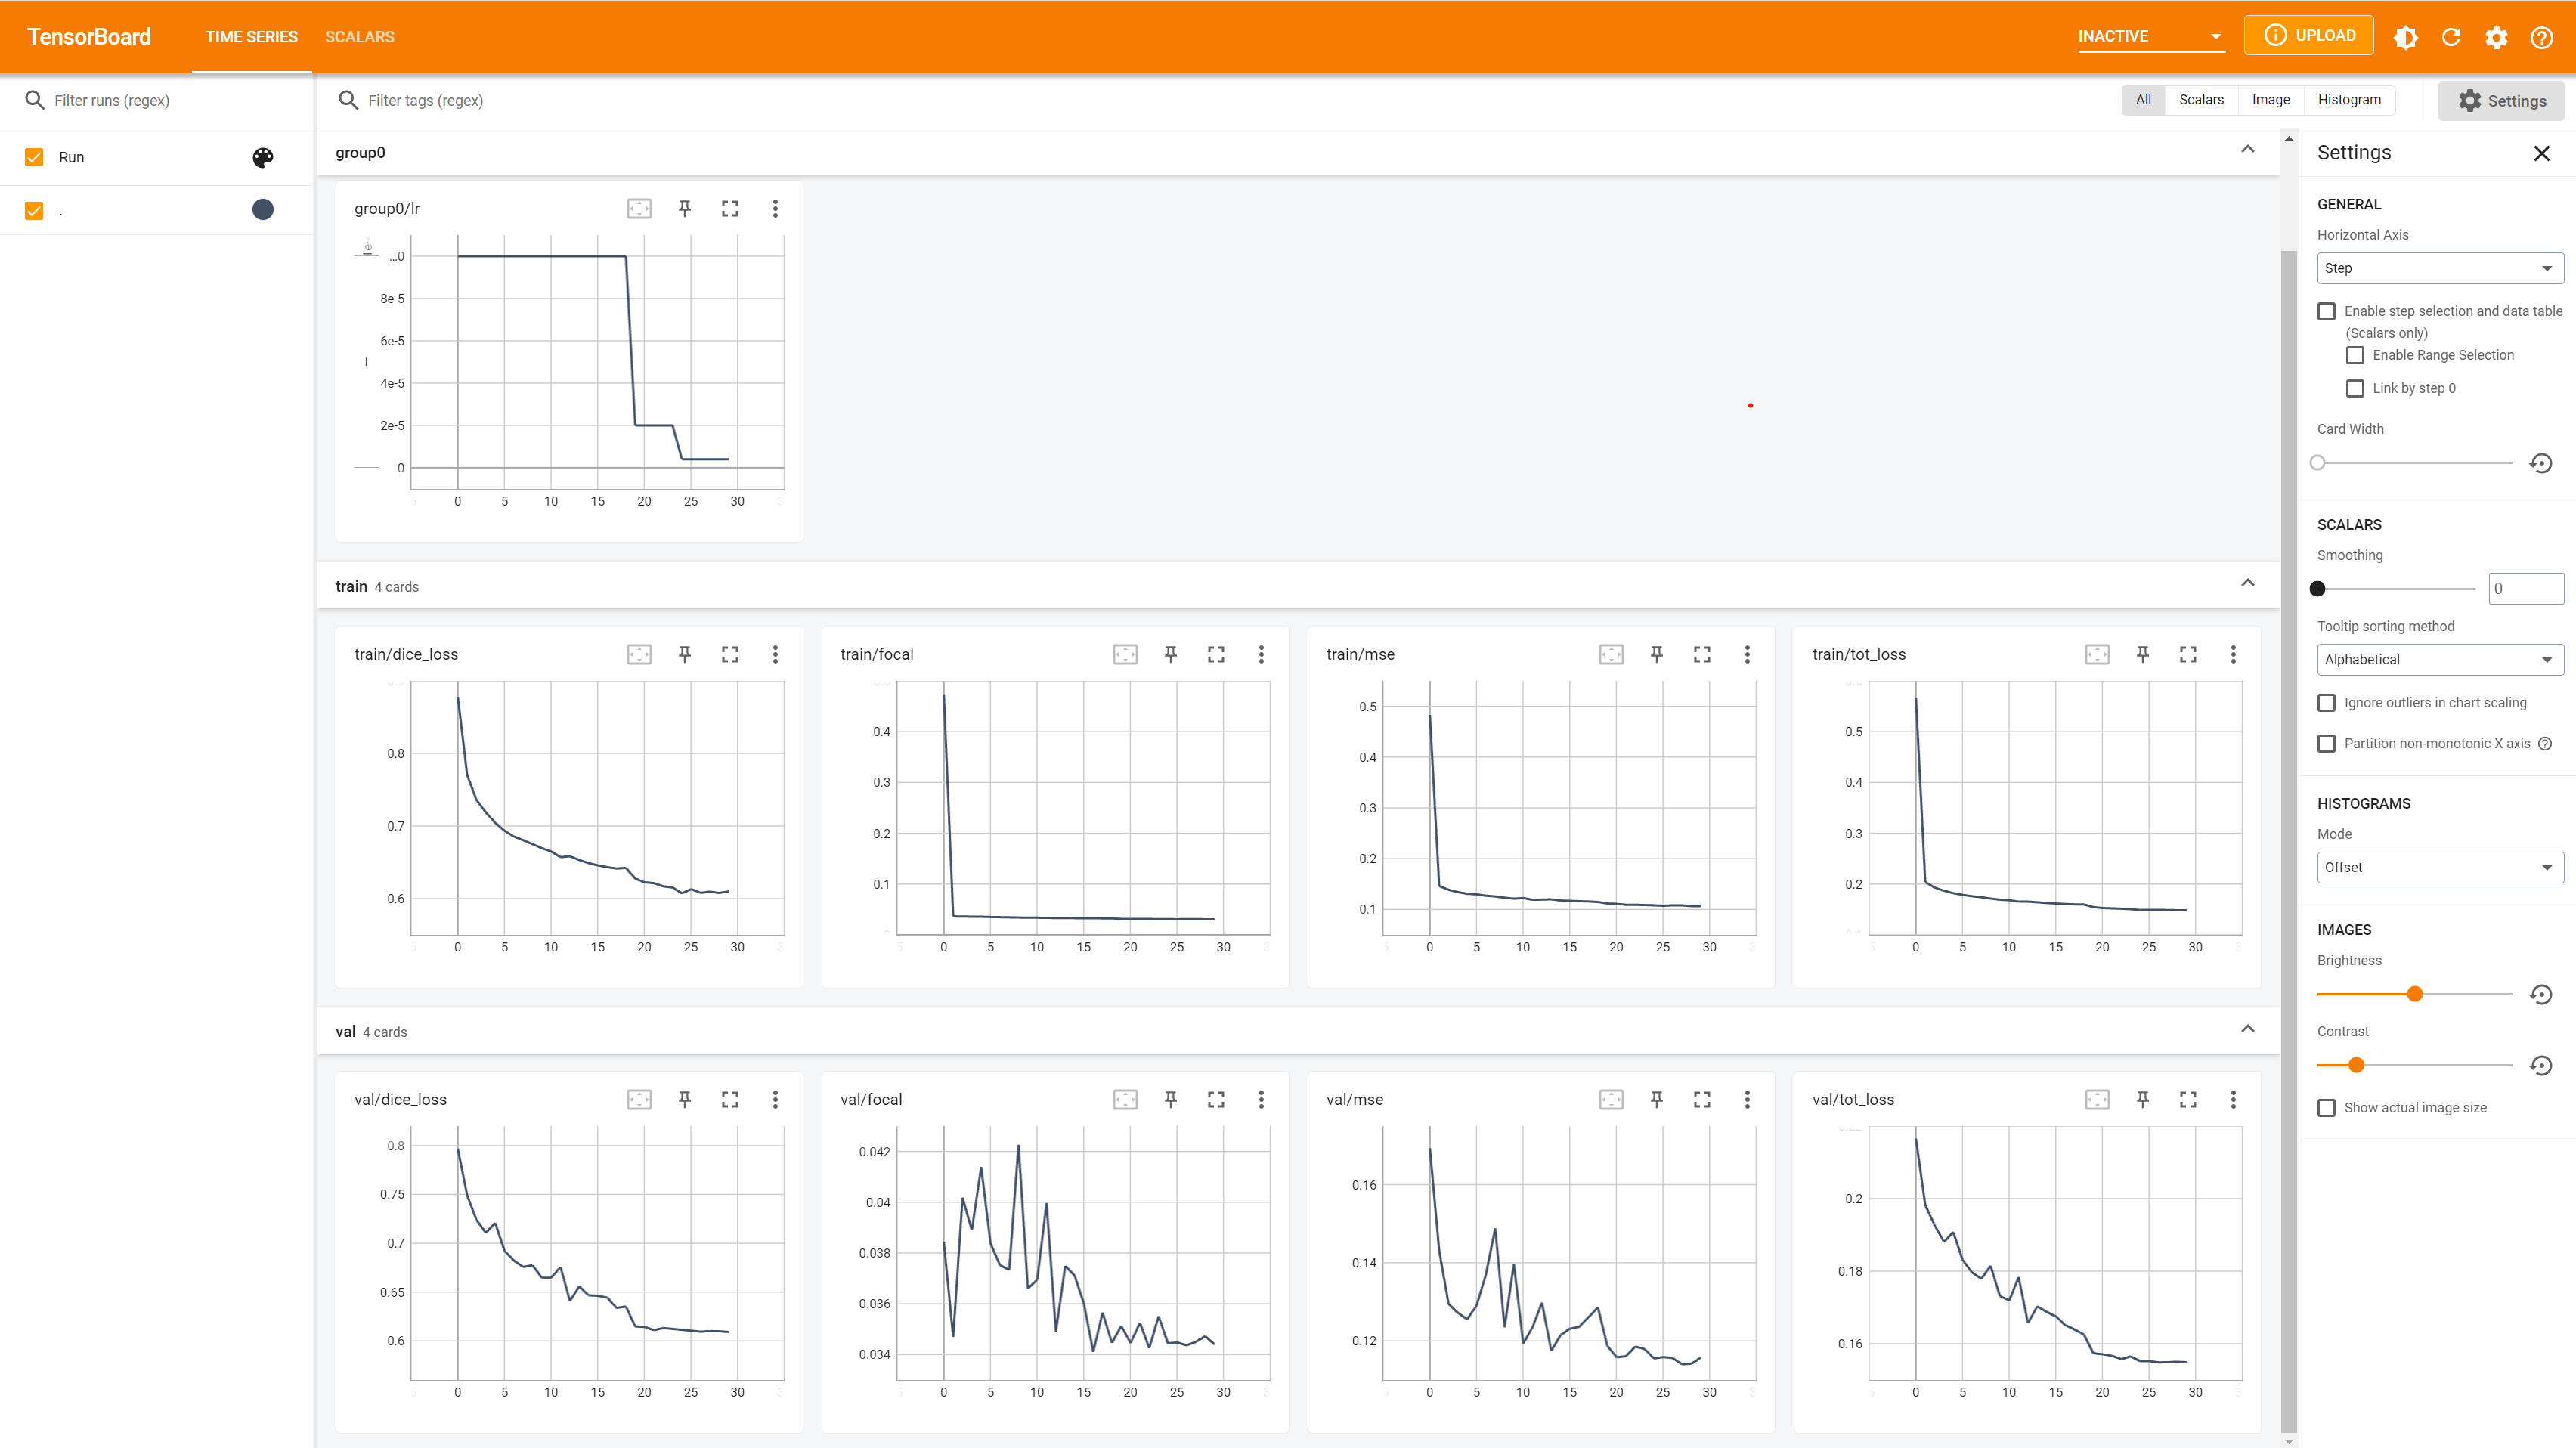



 

# Inference

To run inference, we can use the `02_eval.py` script (https://github.com/avanetten/cresi/blob/main/cresi/02_eval.py). Remember that we did modify a few lines to accomodate AMX and BF16 (see Codebase Changes above).

```bash
python3 /home/devcloud/cresi/cresi/02_eval.py /home/devcloud/cresi/cresi/configs/ben/v10_xeon4_baseline_ben.json
```

Here is a sample mask output that was predicted.

In [9]:
img_path = '/home/devcloud/spacenet5data/moscow/v10_xeon4_devcloud22.04/sn5_baseline/folds/fold0_SN5_roads_test_public_AOI_7_Moscow_PS-MS_chip95.tif'
# inspect
mask_pred = skimage.io.imread(img_path)
print("mask_pred.shape:", mask_pred.shape)

# plot all layers
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
for i, ax in enumerate(axes.flatten()):
    if i < (len(axes.flatten()) - 1):
        title = 'Mask Channel {}'.format(str(i))
    else:
        title = 'Aggregate' 
    ax.imshow(mask_pred[i,:,:])
    ax.set_title(title)

mask_pred.shape: (8, 1300, 1300)


Here is the original image and the mask aggregate prediction.

Text(0.5, 1.0, 'Prediction Mask chip 95')

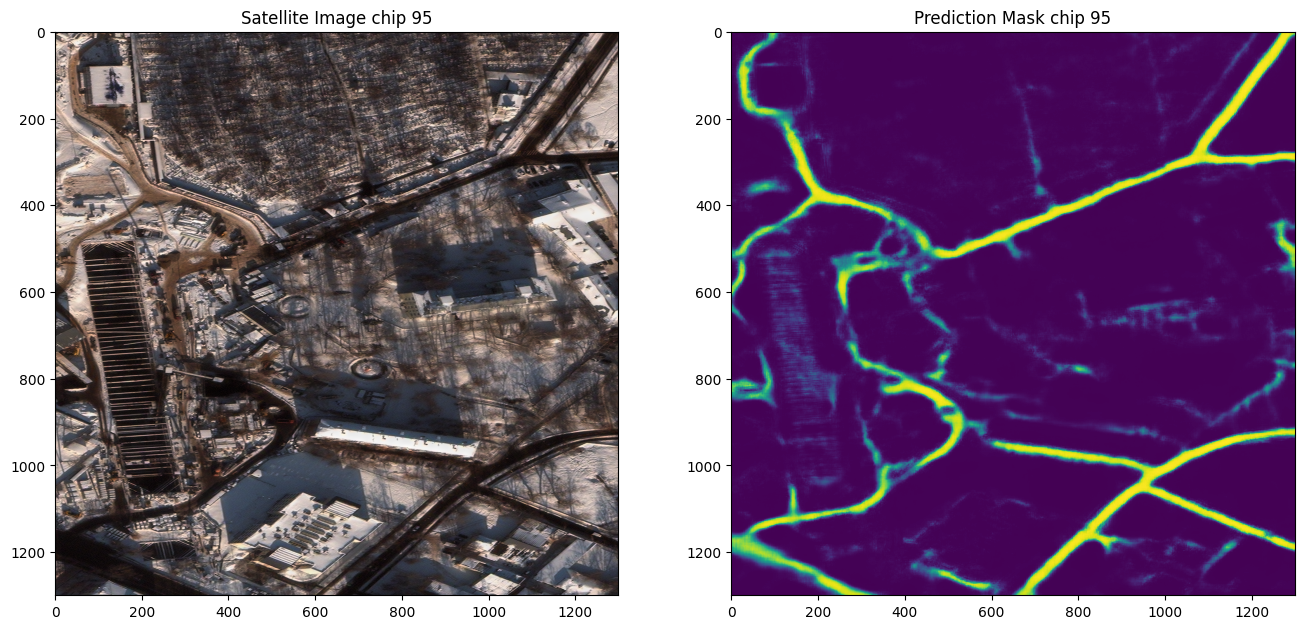

In [10]:
full_path_image = '/home/devcloud/spacenet5data/moscow/test_data/PS-RGB/SN5_roads_test_public_AOI_7_Moscow_PS-RGB_chip95.tif'
full_path_mask = '/home/devcloud/spacenet5data/moscow/v10_xeon4_devcloud22.04/sn5_baseline/folds/fold0_SN5_roads_test_public_AOI_7_Moscow_PS-MS_chip95.tif'

img1 = skimage.io.imread(full_path_image)
img2 = skimage.io.imread(full_path_mask)[7,:,:]

f, axarr = plt.subplots(1,2,figsize=(16, 9))
axarr[0].imshow(img1)
axarr[0].set_title('Satellite Image chip 95')
axarr[1].imshow(img2)
axarr[1].set_title('Prediction Mask chip 95')

# Model Limitations
I realize that the model that I've trained is overfit on the Moscow image data and likely should not generalize well to other cities. However, the [winning solution to this challenge](https://medium.com/the-downlinq/spacenet-5-winning-model-release-end-of-the-road-fd02e00b826c) used data from 6 cities (Las Vegas, Paris, Shanghai, Khartoum, Moscow, Mumbai) and performed well on a new city.

In the future, one thing that would be worth testing is training on all 6 cities and running inference on another city to reproduce their results.

# Post-Processing
**Merge, stitch, skeletonize** <br>
There are further post-processing steps that can be performed to add the mask as graph features to maps. You can read more about the post-processing steps here:
- [The SpaceNet 5 Baseline — Part 3: Extracting Road Speed Vectors from Satellite Imagery](https://medium.com/the-downlinq/the-spacenet-5-baseline-part-3-extracting-road-speed-vectors-from-satellite-imagery-5d07cd5e1d21)

And the post-processing scripts can be found here:
- https://github.com/avanetten/cresi/tree/main/cresi

The text outputs are quite verbose, and so I recommend doing these in a separate terminal (and with tmux), rather than in a notebook.
```bash
python3 /home/devcloud/cresi/cresi/03a_merge_preds.py /home/devcloud/cresi/cresi/configs/ben/v10_xeon4_baseline_ben.json
python3 /home/devcloud/cresi/cresi/03b_stitch.py /home/devcloud/cresi/cresi/configs/ben/v10_xeon4_baseline_ben.json
python3 /home/devcloud/cresi/cresi/04_skeletonize.py /home/devcloud/cresi/cresi/configs/ben/v10_xeon4_baseline_ben.json
python3 /home/devcloud/cresi/cresi/05_wkt_to_G.py /home/devcloud/cresi/cresi/configs/ben/v10_xeon4_baseline_ben.json
```

# Recap
Summary of accomplishments:
- Created 1352 image training masks (with speed limits) to correspond to our training satellite image data (from .geojson text file labels)
- Defined our configuration file for training and inference
- Split up our training and validation data (80/20)
- Optimized our code for CPU training, including using Intel Extension for PyTorch and BF16
- Trained a performant ResNet34 + UNet model on a Sapphire Rapids CPU
- Ran initial inference to see the prediction of a speed limit mask

This fine-tuning of an image segmentation model (for a ResNet34 + UNet model) led to the following observations for me:
1) Deep learning training on CPUs is feasible and even performant on Sapphire Rapids.
2) It was faster to train per epoch with BF16 and Auto Mixed Precision (AMP) training enabled through IPEX than with FP32 stock CPU PyTorch, both on Sapphire Rapids.
3) It was faster to train per epoch on Sapphire Rapids than on the previous 3rd Gen Intel® Xeon® Scalable Processor (Ice Lake c6i.metal AWS instance) with the same code/configurations.
4) It was comparable in training time to an NVIDIA* Tesla T4 GPU (AWS g4dn.2xlarge instance). The difference is for the NVIDIA GPU, of course none of the CPU-specific optimizations were completed. The standard GPU training code at https://github.com/avanetten/cresi was used.

You can find much more detailed benchmarks here for Sapphire Rapids, including statements concerning the NVIDIA A100 GPU: https://edc.intel.com/content/www/us/en/products/performance/benchmarks/4th-generation-intel-xeon-scalable-processors/

> For me as a data scientist, I more care about the fact that I can do a training run over night (or during a workday) than about specific performance benchmarks. The new Sapphire Rapids CPU brings home the new reality of *fine-tuning training on a CPU*, which is exciting. Happy coding!

-----


# Calls To Action:

1. Complete a 5 minute survey here on the talk from today: https://intel.az1.qualtrics.com/jfe/form/SV_cSW1a7tqB9huorc 

2. Start by using the Intel Extension for PyTorch:
 
`pip install intel-extension-for-pytorch`

`git clone https://github.com/intel/intel-extension-for-pytorch`

3. Get on the Intel Developer Cloud [cloud.intel.com](https://cloud.intel.com). Get in touch with me if you want early access to Intel compute!

4. Please let me know if you used the code by connecting with me on one of the following places:

<a href="https://discord.gg/rv2Gp55UJQo" target="Discord"> <img src="https://upload.wikimedia.org/wikipedia/en/9/98/Discord_logo.svg" width="100"/></a> <br> Please join me on Intel's Developer Discord to have further discussion following the talk. **My user is <mark>silvos#5002</mark>** <br>
Invite link: https://discord.gg/rv2Gp55UJQ <br>

And here are the other places you can connect with me:

## <a href="https://www.linkedin.com/in/bconsolvo/" target="LinkedIn"> <img src="https://upload.wikimedia.org/wikipedia/commons/0/01/LinkedIn_Logo.svg" width="60"/></a> | <a href="https://twitter.com/bpconsolvo" target="Twitter"> <img src="https://upload.wikimedia.org/wikipedia/commons/4/4f/Twitter-logo.svg" width="25"/></a> | <a href="https://huggingface.co/bconsolvo" target=""> <img src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="30"/></a> | <a href="https://www.kaggle.com/bconsolvo" target="Kaggle"> <img src="https://www.kaggle.com/static/images/site-logo.svg" width="60"/></a> | <a href="https://www.quora.com/profile/Benjamin-Consolvo" target="Quora"> <img src="https://upload.wikimedia.org/wikipedia/commons/9/91/Quora_logo_2015.svg" width="40"/></a> | <a href="https://www.reddit.com/user/bconsolvo" target="Reddit"> <img src="https://upload.wikimedia.org/wikipedia/commons/b/b4/Reddit_logo.svg" width="40"/></a> | <a href="https://stackoverflow.com/users/12363294/bconsolvo" target="Stack Overflow"> <img src="https://upload.wikimedia.org/wikipedia/commons/0/02/Stack_Overflow_logo.svg" width="90"/></a> | <a href="https://www.twitch.tv/silvosjehoaddah" target="Twitch"> <img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Twitch_logo.svg" width="40"/></a> |  <a href="https://github.com/bconsolvo" target="GitHub"> <img src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" width="25"/></a>
<br>



# Notices and Disclaimers

Intel optimizations, for Intel compilers or other products, may not optimize to the same degree for non-Intel products. Performance varies by use, configuration and other factors. Learn more on the Performance Index site. Performance results are based on testing as of dates shown in configurations and may not reflect all publicly available updates. See backup for configuration details. No product or component can be absolutely secure. Your costs and results may vary. Intel technologies may require enabled hardware, software or service activation. 

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. Other names and brands may be claimed as the property of others.

[*Trademarks](https://www.intel.com/content/www/us/en/legal/trademarks.html)